Based on my learnings from the Deep Learning Specialization offered by [deeplearning.ai](https://www.coursera.org/specializations/deep-learning).

In [2]:
import numpy as np
import math

from urllib import request
import gzip
import pickle

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [3]:
# this function initializes model parameters with zeros 

def initialize_parameters_zeros(layers_dims):
    """
    Arguments:
    layer_dims -- list containing the size of each layer.
    
    Returns:
    parameters -- dictionary containing parameters for all layers "W1", "b1", ..., "WL", "bL":
                    W1 -- weight matrix of shape (layers_dims[1], layers_dims[0])
                    b1 -- bias vector of shape (layers_dims[1], 1)
                    ...
                    WL -- weight matrix of shape (layers_dims[L], layers_dims[L-1])
                    bL -- bias vector of shape (layers_dims[L], 1)
    """
    
    parameters = {}
    L = len(layers_dims)            # number of layers in the network
    
    for l in range(1, L):
        parameters['W' + str(l)] = np.zeros((layers_dims[l], layers_dims[l-1]))
        parameters['b' + str(l)] = np.zeros((layers_dims[l], 1))
        
    return parameters

In [4]:
# this function initializes model parameters randomly

def initialize_parameters_random(layer_dims):
    """
    Arguments:
    layer_dims -- list containing the size of each layer.
    
    Returns:
    parameters -- dictionary containing parameters for all layers "W1", "b1", ..., "WL", "bL":
                    W1 -- weight matrix of shape (layers_dims[1], layers_dims[0])
                    b1 -- bias vector of shape (layers_dims[1], 1)
                    ...
                    WL -- weight matrix of shape (layers_dims[L], layers_dims[L-1])
                    bL -- bias vector of shape (layers_dims[L], 1)
    """
    
    parameters = {}
    L = len(layer_dims)            # number of layers in the network

    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) * 0.01
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        
        assert(parameters['W' + str(l)].shape == (layer_dims[l], layer_dims[l-1]))
        assert(parameters['b' + str(l)].shape == (layer_dims[l], 1))

    return parameters

In [5]:
# this function initializes model parameters using He initialization (He-et-al, 2015)

def initialize_parameters_he(layers_dims):
    """
    Arguments:
    layer_dims -- list containing the size of each layer.
    
    Returns:
    parameters -- dictionary containing parameters for all layers "W1", "b1", ..., "WL", "bL":
                    W1 -- weight matrix of shape (layers_dims[1], layers_dims[0])
                    b1 -- bias vector of shape (layers_dims[1], 1)
                    ...
                    WL -- weight matrix of shape (layers_dims[L], layers_dims[L-1])
                    bL -- bias vector of shape (layers_dims[L], 1)
    """
    
    parameters = {}
    L = len(layers_dims) - 1
     
    for l in range(1, L + 1):
        parameters['W' + str(l)] = np.random.randn(
            layers_dims[l], layers_dims[l-1]) * np.sqrt(2.0 / layers_dims[l-1])
        parameters['b' + str(l)] = np.zeros((layers_dims[l], 1))
        
    return parameters

In [6]:
# this function does linear computation for a given layer during forward propagation

def linear_forward(A, W, b):
    """
    Implement the linear part of a layer's forward propagation.

    Arguments:
    A -- activations from previous layer, shape: (size of previous layer, number of examples)
    W -- weights matrix, shape: (size of current layer, size of previous layer)
    b -- bias vector, shape: (size of the current layer, 1)

    Returns:
    Z -- the input of the activation function, also called pre-activation parameter 
    cache -- tuple containing "A", "W" and "b" ; used for computations during backprop
    """
    
    Z = np.dot(W, A) + b
    
    assert(Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)
    
    return Z, cache

In [7]:
# activation functions for use during forward propagation

def relu(Z):
    """
    Implement the RELU function.

    Arguments:
    Z -- Output of the linear layer, of any shape

    Returns:
    A -- Post-activation parameter, same shape as Z
    cache -- dictionary containing "Z" ; used for computations during backprop
    """
    
    A = np.maximum(0,Z)
    
    assert(A.shape == Z.shape)
    
    cache = Z 
    return A, cache

    
def sigmoid(Z):
    """
    Implements the sigmoid activation in numpy
    
    Arguments:
    Z -- numpy array of any shape
    
    Returns:
    A -- output of sigmoid(z), same shape as Z
    cache -- dictionary containing "Z" ; used for computations during backprop
    """
    
    A = 1/(1+np.exp(-Z))
    cache = Z
    return A, cache

def softmax(Z):
    """Compute softmax values for each sets of scores in Z.
    For stability, we can multiply both the numerator and denominator with a constant c.
    A popular choice of the log(c) constant is −max(z)

    Arguments:
    Z -- numpy array of any shape
    
    Returns:
    A -- output of softmax(z)
    cache -- dictionary containing "Z" ; used for computations during backprop
    """

    expZ = np.exp(Z - np.max(Z))
    A = expZ / expZ.sum(axis=0, keepdims=True)
    
    cache = Z
    return A, cache

In [8]:
# this function implements forward propagation for a given layer,
# with or without dropout

def linear_activation_forward(A_prev, W, b, activation, keep_prob=1.0):
    """
    Implement the forward propagation for the LINEAR->ACTIVATION layer

    Arguments:
    A_prev -- activations from previous layer, shape: (size of previous layer, number of examples)
    W -- weights matrix, shape: (size of current layer, size of previous layer)
    b -- bias vector, shape: (size of the current layer, 1)
    activation -- the activation to be used in this layer: "sigmoid", "relu" or "softmax"
    keep_prob -- probability of keeping a hidden unit active during drop-out, scalar

    Returns:
    A -- the output of the activation function, also called the post-activation value 
    cache -- tuple containing "linear_cache" and "activation_cache";
             used for computations during backprop
    """
    
    Z, linear_cache = linear_forward(A_prev, W, b)

    if activation == "sigmoid":        
        A, activation_cache = sigmoid(Z)

    elif activation == "relu":
        A, activation_cache = relu(Z)

    elif activation == "softmax":
        A, activation_cache = softmax(Z)
           
    if keep_prob < 1:
        # initialize matrix D
        D = np.random.rand(A.shape[0], A.shape[1])   
        # convert entries of D to 0 or 1 (using keep_prob as the threshold)
        D = (D < keep_prob).astype(int)       
        # shut down some hidden units of A
        A = np.multiply(A, D)                           
        A = A / keep_prob
        activation_cache = (activation_cache, D)
        
    assert (A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)
    
    return A, cache

In [9]:
# this function implements forward propagation through all the layers,
# with or without dropout

def L_model_forward(X, parameters, keep_prob=1.0):
    """
    Implement forward propagation for the [LINEAR->RELU]*(L-1)->LINEAR->SOFTMAX layers
    
    Arguments:
    X -- input data, shape: (input size, number of examples)
    parameters -- output of model parameter initialization
    keep_prob -- probability of keeping a hidden unit active during drop-out, scalar

    Returns:
    AL -- last post-activation value
    caches -- list of caches containing every cache of linear_activation_forward();
    there are L of them, indexed from 0 to L-1
    """

    caches = []
    A = X
    L = len(parameters) // 2                  # number of layers in the neural network
    
    # Implement [LINEAR -> RELU]*(L-1). Add "cache" to the "caches" list.
    for l in range(1, L):
        A_prev = A 
        A, cache = linear_activation_forward(A_prev, 
                                             parameters['W' + str(l)], 
                                             parameters['b' + str(l)], 
                                             "relu", 
                                             keep_prob)
        caches.append(cache)
    
    # Implement LINEAR -> SOFTMAX. Add "cache" to the "caches" list
    AL, cache = linear_activation_forward(A,
                                          parameters['W' + str(L)], 
                                          parameters['b' + str(L)], 
                                          "softmax")
    caches.append(cache)
            
    return AL, caches

In [10]:
# this function computes the cross-entropy cost

def compute_cost(AL, Y):
    """
    Implement the cost function for multinomial classification

    Arguments:
    AL -- probability vector corresponding to label predictions, 
    shape: (number of classes, number of examples)
    Y -- one-hot encoded "true" label vector, 
    shape: (number of classes, number of examples)

    Returns:
    cost -- cross-entropy cost
    """
    
    m = Y.shape[1]

    # compute cost
    cost = (-1.0 / m) * np.nansum(Y * np.log(AL)) 
    
    cost = np.squeeze(cost)      
    assert(cost.shape == ())
    
    return cost

In [11]:
# this function computes cost when the model is L2 regularized

def compute_cost_with_regularization(AL, Y, parameters, lambd):
    """
    Implement the cost function with L2 regularization
    
    Arguments:
    AL -- probability vector corresponding to label predictions, 
    shape: (number of classes, number of examples)
    Y -- one-hot encoded "true" label vector, 
    shape: (number of classes, number of examples)
    parameters -- dictionary containing model parameters
    lambd -- regularization hyperparameter, scalar
    
    Returns:
    cost - value of the regularized loss function for multinomial classification
    """
    
    L = len(parameters) // 2    # number of layers in the neural network
    
    m = Y.shape[1]

    cross_entropy_cost = compute_cost(AL, Y) # cross-entropy part of the cost

    # regularization cost
    param_sum = 0
    for l in range(1, L):
      param_sum += np.sum(np.square(parameters['W' + str(l)]))

    param_sum += np.sum(np.square(parameters['W' + str(L)]))
    L2_regularization_cost = (lambd / (2.0*m)) * param_sum
    
    # total cost
    cost = cross_entropy_cost + L2_regularization_cost
    
    return cost

In [12]:
# this function does linear computation for a given layer during backward propagation

def linear_backward(dZ, cache):
    """
    Implement the linear portion of backward propagation for a single layer (layer l)

    Arguments:
    dZ -- Gradient of the cost with respect to the linear output (of current layer l)
    cache -- tuple of values (A_prev, W, b) coming from the forward propagation in the current layer

    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1),
    same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), 
    same shape as W
    db -- Gradient of the cost with respect to b (current layer l), 
    same shape as b
    """
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = (1.0/m) * np.dot(dZ, A_prev.T)
    db = (1.0/m) * np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(W.T, dZ)
    
    assert (dA_prev.shape == A_prev.shape)
    assert (dW.shape == W.shape)
    assert (db.shape == b.shape)
    
    return dA_prev, dW, db

In [13]:
# gradients of activation functions for use during backward propagation

def relu_backward(dA, Z):
    """
    Implement the backward propagation for a single RELU unit.

    Arguments:
    dA -- post-activation gradient, of any shape
    Z -- linear computation from forward propagation through the layer

    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    
    dZ = np.array(dA, copy=True) # convert dZ to a correct object.
    
    # When Z <= 0, set dZ to 0
    dZ[Z <= 0] = 0
    
    assert (dZ.shape == Z.shape)
    
    return dZ


def sigmoid_backward(dA, Z):
    """
    Implement the backward propagation for a single SIGMOID unit.

    Arguments:
    dA -- post-activation gradient, of any shape
    Z -- linear computation from forward propagation through the layer

    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    
    assert (dZ.shape == Z.shape)
    
    return dZ

In [14]:
# this function implements backward propagation for a given non-output layer,
# with or without dropout

def linear_activation_backward(dA, cache, activation, keep_prob=1.0):
    """
    Implement the backward propagation for the LINEAR->ACTIVATION for non-output layers.
    
    Arguments:
    dA -- post-activation gradient for current layer l 
    cache -- tuple of (linear_cache, activation_cache) from forward propagation through the layer
    activation -- the activation to be used in this layer: "sigmoid" or "relu" 
    keep_prob -- probability of keeping a hidden unit active during drop-out, scalar

    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), 
    same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    linear_cache, activation_cache = cache

    if keep_prob < 1:
        (Z, D) = activation_cache
        # Apply mask D to shut down the same hidden units as during the forward propagation
        dA = np.multiply(dA, D)
        # Scale the value of hidden units that haven't been shut down  
        dA = dA / keep_prob 
    else:
        Z = activation_cache

    if activation == "relu":
        dZ = relu_backward(dA, Z)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        
    elif activation == "sigmoid":
        dZ = sigmoid_backward(dA, Z)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)     

    return dA_prev, dW, db

In [15]:
# this function implements backward propagation through all the layers,
# with or without dropout

def L_model_backward(AL, Y, caches, keep_prob=1.0):
    """
    Implement backward propagation for the [LINEAR->RELU]*(L-1)->LINEAR->SOFTMAX layers
    
    Arguments:
    AL -- probability vector corresponding to label predictions, 
    shape: (number of classes, number of examples)
    Y -- one-hot encoded "true" label vector, 
    shape: (number of classes, number of examples)
    caches -- list of caches containing every cache of linear_activation_forward();
    there are L of them, indexed from 0 to L-1
    keep_prob -- probability of keeping a hidden unit active during drop-out, scalar
    
    Returns:
    grads -- A dictionary with the gradients
             grads["dA" + str(l)] = ... 
             grads["dW" + str(l)] = ...
             grads["db" + str(l)] = ... 
    """
    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) 
    
    # Lth layer (SOFTMAX -> LINEAR) gradients
    linear_cache, activation_cache = caches[L-1]
    A_prev, WL, bL = linear_cache
    
    dZL = AL - Y
    dWL = 1./m * np.dot(dZL, A_prev.T)
    dbL = 1./m * np.sum(dZL, axis=1, keepdims = True)
    dA_prev_temp = np.dot(WL.T, dZL)

    grads["dW" + str(L)] = dWL
    grads["db" + str(L)] = dbL
    grads["dA" + str(L-1)] = dA_prev_temp

    # Loop from l=L-2 to l=0
    for l in reversed(range(L-1)):
        # lth layer: (RELU -> LINEAR) gradients
        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l+1)],
                                                                    current_cache,
                                                                    "relu",
                                                                    keep_prob)
        
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp
        
    return grads

In [16]:
# this function implements backward propagation through all the layers,
# with L2 regularization

def L_model_backward_with_regularization(AL, Y, caches, lambd):
    """
    Implement the backward propagation for the [LINEAR->RELU] * (L-1) -> LINEAR -> SIGMOID group
    
    Arguments:
    AL -- probability vector corresponding to label predictions, 
    shape: (number of classes, number of examples)
    Y -- one-hot encoded "true" label vector, 
    shape: (number of classes, number of examples)
    caches -- list of caches containing every cache of linear_activation_forward();
    there are L of them, indexed from 0 to L-1
    lambd -- regularization hyperparameter, scalar
    
    Returns:
    grads -- A dictionary with the gradients
             grads["dA" + str(l)] = ... 
             grads["dW" + str(l)] = ...
             grads["db" + str(l)] = ... 
    """
    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)

    # Lth layer (SOFTMAX -> LINEAR) gradients
    linear_cache, activation_cache = caches[L-1]
    A_prev, WL, bL = linear_cache
    
    dZL = AL - Y
    dWL = 1./m * np.dot(dZL, A_prev.T) + ((lambd / m) * WL)
    dbL = 1./m * np.sum(dZL, axis=1, keepdims = True)
    dA_prev_temp = np.dot(WL.T, dZL)

    grads["dW" + str(L)] = dWL
    grads["db" + str(L)] = dbL
    grads["dA" + str(L-1)] = dA_prev_temp

    A = A_prev    
    
    # Loop from l=L-2 to l=0
    for l in reversed(range(L-1)):
        # lth layer: (RELU -> LINEAR) gradients.
        linear_cache, activation_cache = caches[l]
        A_prev, W, b = linear_cache

        dZ = np.multiply(grads["dA" + str(l + 1)], np.int64(A > 0))
        dW_temp = 1./m * np.dot(dZ, A_prev.T) + ((lambd / m) * W)
        db_temp = 1./m * np.sum(dZ, axis=1, keepdims = True)
        dA_prev_temp = np.dot(W.T, dZ)
        
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp
        grads["dA" + str(l)] = dA_prev_temp

        A = A_prev
        
    return grads

In [17]:
# this function randomly generated minibatches from the entire training data

def random_mini_batches(X, Y, mini_batch_size = 500):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, shape: (input size, number of examples)
    Y -- one-hot encoded "true" label vector, shape: (number of classes, number of examples)
    mini_batch_size -- size of the mini-batches, integer
    
    Returns:
    mini_batches -- list of (mini_batch_X, mini_batch_Y)
    """
    
    m = X.shape[1]                  # number of training examples
    mini_batches = []
        
    # Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation]

    # Partition (shuffled_X, shuffled_Y)
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k * mini_batch_size : (k+1) * mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size : (k+1) * mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [18]:
# this function initializes the velocity for use in gradient descent with momentum

def initialize_velocity(parameters):
    """
    Initializes the velocity as a dictionary with:
                - keys: "dW1", "db1", ..., "dWL", "dbL" 
                - values: numpy arrays of zeros, same shape as the corresponding gradients/parameters
    Arguments:
    parameters -- dictionary containing model parameters
                    parameters['W' + str(l)] = Wl
                    parameters['b' + str(l)] = bl
    
    Returns:
    v -- dictionary containing the current velocity
                    v['dW' + str(l)] = velocity of dWl
                    v['db' + str(l)] = velocity of dbl
    """
    
    L = len(parameters) // 2 # number of layers in the neural networks
    v = {}
    
    # Initialize velocity
    for l in range(L):
        v["dW" + str(l+1)] = np.zeros((parameters['W' + str(l+1)].shape[0], 
                                       parameters['W' + str(l+1)].shape[1]))
        v["db" + str(l+1)] = np.zeros((parameters['b' + str(l+1)].shape[0], 
                                       parameters['b' + str(l+1)].shape[1]))
        
    return v

In [19]:
# this function initializes first and second moments for use in Adam optimizer

def initialize_adam(parameters) :
    """
    Initializes v and s as two dictionaries with:
                - keys: "dW1", "db1", ..., "dWL", "dbL" 
                - values: numpy arrays of zeros, same shape as the corresponding gradients/parameters
    
    Arguments:
    parameters -- dictionary containing model parameters
                    parameters["W" + str(l)] = Wl
                    parameters["b" + str(l)] = bl
    
    Returns: 
    v -- dictionary that will contain the exponentially weighted average of the gradient
                    v["dW" + str(l)] = ...
                    v["db" + str(l)] = ...
    s -- dictionary that will contain the exponentially weighted average of the squared gradient
                    s["dW" + str(l)] = ...
                    s["db" + str(l)] = ...

    """
    
    L = len(parameters) // 2 # number of layers in the neural networks
    v = {}
    s = {}
    
    # Initialize v, s
    for l in range(L):
        v["dW" + str(l+1)] = np.zeros((parameters["W" + str(l+1)].shape[0], 
                                       parameters["W" + str(l+1)].shape[1]))
        v["db" + str(l+1)] = np.zeros((parameters["b" + str(l+1)].shape[0], 
                                       parameters["b" + str(l+1)].shape[1]))
        s["dW" + str(l+1)] = np.zeros((parameters["W" + str(l+1)].shape[0], 
                                       parameters["W" + str(l+1)].shape[1]))
        s["db" + str(l+1)] = np.zeros((parameters["b" + str(l+1)].shape[0], 
                                       parameters["b" + str(l+1)].shape[1]))
    
    return v, s

In [20]:
# this function updates model parameters using one step of gradient descent

def update_parameters_with_gd(parameters, grads, learning_rate):
    """
    Update parameters using (minibatch) gradient descent
    
    Arguments:
    parameters -- dictionary containing model parameters
                    parameters['W' + str(l)] = Wl
                    parameters['b' + str(l)] = bl
    grads -- dictionary containing parameter gradients, output of L_model_backward
                    grads['dW' + str(l)] = dWl
                    grads['db' + str(l)] = dbl
    learning_rate -- determines step sizes during optimization, scalar
    
    Returns:
    parameters -- dictionary containing updated parameters 
                  parameters["W" + str(l)] = ... 
                  parameters["b" + str(l)] = ...
    """
    
    L = len(parameters) // 2 # number of layers in the neural network

    # Update rule for each parameter
    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] 
        - (learning_rate * grads["dW" + str(l+1)])
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] 
        - (learning_rate * grads["db" + str(l+1)])

    return parameters

In [21]:
# this function updates model parameters when using momentum

def update_parameters_with_momentum(parameters, grads, v, beta, learning_rate):
    """
    Update parameters using Momentum
    
    Arguments:
    parameters -- dictionary containing model parameters
                    parameters['W' + str(l)] = Wl
                    parameters['b' + str(l)] = bl
    grads -- dictionary containing parameter gradients, output of L_model_backward
                    grads['dW' + str(l)] = dWl
                    grads['db' + str(l)] = dbl
    v -- dictionary containing the current velocity
                    v['dW' + str(l)] = ...
                    v['db' + str(l)] = ...
    beta -- the momentum hyperparameter, scalar
    learning_rate -- determines step sizes during optimization, scalar
    
    Returns:
    parameters -- dictionary containing updated parameters 
    v -- dictionary containing updated velocities
    """

    L = len(parameters) // 2 # number of layers in the neural networks
    
    # Momentum update for each parameter
    for l in range(L):
        # compute velocities
        v["dW" + str(l+1)] = (beta * v["dW" + str(l+1)]) + ((1.0 - beta) * grads["dW" + str(l+1)])
        v["db" + str(l+1)] = (beta * v["db" + str(l+1)]) + ((1.0 - beta) * grads["db" + str(l+1)])
        # update parameters
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - (learning_rate * v["dW" + str(l+1)])
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - (learning_rate * v["db" + str(l+1)])
        
    return parameters, v

In [22]:
# this function updates model parameters when using Adam optimizer

def update_parameters_with_adam(parameters, grads, v, s, t, learning_rate = 0.01,
                                beta1 = 0.9, beta2 = 0.999,  epsilon = 1e-8):
    """
    Update parameters using Adam
    
    Arguments:
    parameters -- dictionary containing model parameters
                    parameters['W' + str(l)] = Wl
                    parameters['b' + str(l)] = bl
    grads -- dictionary containing parameter gradients, output of L_model_backward
                    grads['dW' + str(l)] = dWl
                    grads['db' + str(l)] = dbl
    v -- Adam variable, moving average of the first gradient, dictionary
    s -- Adam variable, moving average of the squared gradient, dictionary
    t -- counter required for Adam update, scalar
    learning_rate -- determines step sizes during optimization, scalar
    beta1 -- Exponential decay hyperparameter for the first moment estimates 
    beta2 -- Exponential decay hyperparameter for the second moment estimates 
    epsilon -- hyperparameter preventing division by zero in Adam updates

    Returns:
    parameters -- dictionary containing updated parameters 
    v -- Adam variable, moving average of the first gradient, dictionary
    s -- Adam variable, moving average of the squared gradient, dictionary
    """
    
    L = len(parameters) // 2                 # number of layers in the neural networks
    v_corrected = {}                         # Initializing first moment estimate, python dictionary
    s_corrected = {}                         # Initializing second moment estimate, python dictionary
    
    # Perform Adam update on all parameters
    for l in range(L):
        # Moving average of the gradients
        v["dW" + str(l+1)] = (beta1 * v["dW" + str(l+1)]) + ((1.0 - beta1) * grads['dW' + str(l+1)])
        v["db" + str(l+1)] = (beta1 * v["db" + str(l+1)]) + ((1.0 - beta1) * grads['db' + str(l+1)])

        # Compute bias-corrected first moment estimate
        v_corrected["dW" + str(l+1)] = v["dW" + str(l+1)] / (1.0 - math.pow(beta1, t))
        v_corrected["db" + str(l+1)] = v["db" + str(l+1)] / (1.0 - math.pow(beta1, t))

        # Moving average of the squared gradients
        s["dW" + str(l+1)] = \
            (beta2 * s["dW" + str(l+1)]) + ((1.0 - beta2) * np.multiply(grads['dW' + str(l+1)], 
                                                                        grads['dW' + str(l+1)]))
        s["db" + str(l+1)] = \
            (beta2 * s["db" + str(l+1)]) + ((1.0 - beta2) * np.multiply(grads['db' + str(l+1)], 
                                                                        grads['db' + str(l+1)]))

        # Compute bias-corrected second raw moment estimate
        s_corrected["dW" + str(l+1)] = s["dW" + str(l+1)] / (1.0 - math.pow(beta2, t))
        s_corrected["db" + str(l+1)] = s["db" + str(l+1)] / (1.0 - math.pow(beta2, t))

        # Update parameters
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - \
            (learning_rate * 
             (v_corrected["dW" + str(l+1)] / np.sqrt(s_corrected["dW" + str(l+1)] + epsilon)))
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - \
            (learning_rate * 
             (v_corrected["db" + str(l+1)] / np.sqrt(s_corrected["db" + str(l+1)] + epsilon)))

    return parameters, v, s

In [23]:
# this function implements the L-layer neural network model

def L_layer_model(X, Y, layers_dims, optimizer="adam", learning_rate = 0.0007, 
                  mini_batch_size = 500, beta = 0.9, beta1 = 0.9, beta2 = 0.999, 
                  epsilon = 1e-8, num_epochs = 10000, print_cost=False, 
                  initialization="he", lambd = 0, keep_prob = 1.0):
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SOFTMAX
    
    Arguments:
    X -- input data, shape: (input size, number of examples)
    Y -- one-hot encoded "true" label vector, shape: (number of classes, number of examples)
    layers_dims -- list containing number of hidden units for each layer
    optimizer -- the optimizer to be used: "gd", "momentum" or "adam" 
    learning_rate -- determines step sizes during optimization, scalar
    mini_batch_size -- the size of a mini batch
    beta -- Momentum hyperparameter
    beta1 -- Exponential decay hyperparameter for the first moment estimates 
    beta2 -- Exponential decay hyperparameter for the second moment estimates 
    epsilon -- hyperparameter preventing division by zero in Adam updates
    num_epochs -- number of passes over the training set during optimization
    print_cost -- True to print the cost every 1000 epochs
    initialization -- initialization to be used for model parameters: "zeros", "random" or "he"
    lambd -- regularization hyperparameter, scalar
    keep_prob -- probability of keeping a hidden unit active during drop-out, scalar
    
    Returns:
    parameters -- parameters learnt by the model; used for making predictions
    """

    costs = []                         # keep track of cost
    t = 0             # initializing the counter required for Adam update
    m = X.shape[1]                   # number of training examples


    # Initialize parameters
    if initialization == "zeros":
        parameters = initialize_parameters_zeros(layers_dims)
    elif initialization == "random":
        parameters = initialize_parameters_random(layers_dims)
    elif initialization == "he":
        parameters = initialize_parameters_he(layers_dims)
    
    # Initialize the optimizer
    if optimizer == "gd":
        pass # no initialization required for gradient descent
    elif optimizer == "momentum":
        v = initialize_velocity(parameters)
    elif optimizer == "adam":
        v, s = initialize_adam(parameters)

    # Optimization loop
    for i in range(0, num_epochs):
        minibatches = random_mini_batches(X, Y, mini_batch_size)
        cost_total = 0

        for minibatch in minibatches:

            # Select a minibatch
            (minibatch_X, minibatch_Y) = minibatch

            # Forward propagation
            AL, caches = L_model_forward(minibatch_X, parameters, keep_prob)
        
            # Cost function
            if lambd == 0:
                cost_total += compute_cost(AL, minibatch_Y)
            else:
                cost_total += compute_cost_with_regularization(AL, minibatch_Y, parameters, lambd)
    
            # Backward propagation.
            if lambd == 0:
                grads = L_model_backward(AL, minibatch_Y, caches, keep_prob)
            else:
                grads = L_model_backward_with_regularization(AL, minibatch_Y, caches, lambd)

            # Update parameters
            if optimizer == "gd":
                parameters = update_parameters_with_gd(parameters, grads, learning_rate)
            elif optimizer == "momentum":
                parameters, v = update_parameters_with_momentum(parameters, grads, v, beta, learning_rate)
            elif optimizer == "adam":
                t = t + 1 # Adam counter
                parameters, v, s = update_parameters_with_adam(parameters, grads, v, s,
                                                               t, learning_rate, beta1, beta2,  epsilon)
                
        cost_avg = cost_total / m
        
        # Print the cost every 1000 epoch
        if print_cost and i % 1000 == 0:
            print ("Cost after epoch %i: %f" %(i, cost_avg))
        if print_cost and i % 100 == 0:
            costs.append(cost_avg)
            
    # plot the cost
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('epochs (per 100)')
    plt.title("Learning rate = " + str(learning_rate))
    plt.show()
    
    return parameters

In [24]:
# Loading the dataset

filename = [
["training_images","train-images-idx3-ubyte.gz"],
["test_images","t10k-images-idx3-ubyte.gz"],
["training_labels","train-labels-idx1-ubyte.gz"],
["test_labels","t10k-labels-idx1-ubyte.gz"]
]

def download_mnist():
    base_url = "http://yann.lecun.com/exdb/mnist/"
    for name in filename:
        print("Downloading "+name[1])
        request.urlretrieve(base_url+name[1], name[1])
    print("Download complete.")

def save_mnist():
    mnist = {}
    for name in filename[:2]:
        with gzip.open(name[1], 'rb') as f:
            temp_x = np.frombuffer(f.read(), np.uint8, offset=16).reshape(-1, 28*28).T
            mnist[name[0]] = temp_x.reshape(28, 28, temp_x.shape[1])
    for name in filename[-2:]:
        with gzip.open(name[1], 'rb') as f:
            temp_y = np.frombuffer(f.read(), np.uint8, offset=8)
            mnist[name[0]] = temp_y.reshape(1, temp_y.shape[0])
    with open("mnist.pkl", 'wb') as f:
        pickle.dump(mnist,f)
    print("Save complete.")

def load_dataset():
    with open("mnist.pkl",'rb') as f:
        mnist = pickle.load(f)
    return mnist["training_images"], mnist["training_labels"], mnist["test_images"], mnist["test_labels"]

download_mnist()
save_mnist()

X_train_orig, Y_train_orig, X_test_orig, Y_test_orig = load_dataset()
num_classes = len(np.unique(Y_test_orig))

print ("X_train_orig shape: " + str(X_train_orig.shape))
print ("Y_train_orig shape: " + str(Y_train_orig.shape))
print ("X_test_orig shape: " + str(X_test_orig.shape))
print ("Y_test_orig shape: " + str(Y_test_orig.shape))

Download complete.
Save complete.
X_train_orig shape: (28, 28, 60000)
Y_train_orig shape: (1, 60000)
X_test_orig shape: (28, 28, 10000)
Y_test_orig shape: (1, 10000)


y = 3


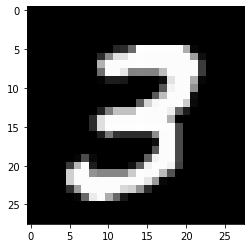

In [25]:
# Example of a picture
index = 7
plt.imshow(X_train_orig[:,:,index])
print ("y = " + str(np.squeeze(Y_train_orig[:,index])))

In [29]:
# this function encodes true label vector with one-hot encoding

def convert_to_one_hot(Y_raw, C):
  """
    Encode true label vector with one-hot encoding
    
    Arguments:
    Y_raw -- true label vector, size: (1, number of training examples)
    C -- number of possible classes for labels

    Returns:
    Y -- one-hot encoded "true" label vector, shape: (number of classes, number of examples)
  """
    
  Y = np.eye(C)[Y_raw.reshape(-1)].T
  return Y

In [31]:
# Flatten the training and test images
X_train_flatten = X_train_orig.reshape(
    X_train_orig.shape[0]*X_train_orig.shape[1], X_train_orig.shape[2])
X_test_flatten = X_test_orig.reshape(
    X_test_orig.shape[0]*X_test_orig.shape[1], X_test_orig.shape[2])

# Normalize image vectors
X_train = X_train_flatten/255.
X_test = X_test_flatten/255.

# Convert training and test labels to one hot matrices
Y_train = convert_to_one_hot(Y_train_orig, num_classes)
Y_test = convert_to_one_hot(Y_test_orig, num_classes)

print ("number of label classes = " + str(num_classes))
print ("number of training examples = " + str(X_train.shape[1]))
print ("number of test examples = " + str(X_test.shape[1]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

number of label classes = 10
number of training examples = 60000
number of test examples = 10000
X_train shape: (784, 60000)
Y_train shape: (10, 60000)
X_test shape: (784, 10000)
Y_test shape: (10, 10000)


In [32]:
# define number of hidden units in each layer

layers_dims = [X_train.shape[0], 30, num_classes] #  2-layer model

Cost after epoch 0: 0.002375
Cost after epoch 1000: 0.000088


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in multiply


Cost after epoch 2000: 0.000079
Cost after epoch 3000: 0.000071
Cost after epoch 4000: 0.000073
Cost after epoch 5000: 0.000072
Cost after epoch 6000: 0.000066
Cost after epoch 7000: 0.000065
Cost after epoch 8000: 0.000063
Cost after epoch 9000: 0.000063


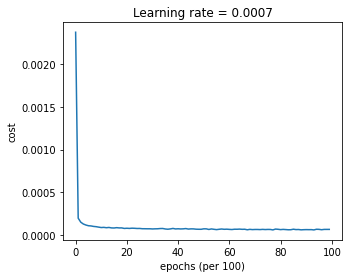

In [33]:
# training the model

# non regularized model
# parameters = L_layer_model(X_train, Y_train, layers_dims, print_cost = True)

# model with L2 regularization
# parameters = L_layer_model(X_train, Y_train, layers_dims, print_cost = True, lambd = 0.7)

# model with dropout
parameters = L_layer_model(X_train, Y_train, layers_dims, print_cost = True, keep_prob = 0.86)

In [37]:
# this function predicts the output for a validation/test set using the learnt neural network

def predict(X, Y, parameters):
    """
    This function is used to predict the results of a  L-layer neural network.
    
    Arguments:
    X -- data set of examples you would like to label
    Y -- one-hot encoded "true" label vector
    parameters -- parameters of the trained model
    
    Returns:
    p -- predictions for the given dataset X
    """
    
    m = X.shape[1]
    n = len(parameters) // 2 # number of layers in the neural network
    p = np.zeros((1,m))
    y = np.zeros((1,m))
    
    # Forward propagation
    probas, caches = L_model_forward(X, parameters)

    
    # convert probas to one of 0....k predicted labels
    for i in range(0, probas.shape[1]):
        p[0,i] = np.argmax(probas[:,i])
        y[0,i] = np.argmax(Y[:,i])
      
    print("Accuracy: "  + str(np.sum((p == y)/m)))
        
    return p

In [38]:
# training accuracy

pred_train = predict(X_train, Y_train, parameters)

Accuracy: 0.9995666666666667


In [39]:
# validation/test accuracy

pred_test = predict(X_test, Y_test, parameters)

Accuracy: 0.9459000000000003
